In [1]:
%matplotlib inline
%run support.py
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
plt.style.use('~/Shared JupyterHub Notebooks/interactive.mplstyle')
#datafolder = "/mnt/Measurement_Data/phys-dots-26/Cooldown20200826"
datafolder = "./data/Measurements/Cooldown20200826"

# Demagnetization

In [2]:
filename = f"d637_time.h5"
removepoints = [0,1]                         # I am removing the first couple of points because the magnetic field was not read correctly there. Only 3 points
removepoints.extend(list(range(2422, 2442))) # I am removing these points because they are spikes related to changing
removepoints.extend(list(range(3024, 3044))) # the excitation on the lock-in, reproducible, and well understood.

with h5py.File(f"{datafolder}/{filename}", 'r') as f:
    t_demag = np.delete(np.array(f['x_array']), removepoints)
    gCu = np.delete(np.array(f['gCu']), removepoints)
    b_demag = np.delete(np.array(f['bdemagIPSB']), removepoints)
    b_demag[0:2]=b_demag[2:4]
Bf = b_demag[-1]
gCu_demag = 1/(1/MakeSmoothie(gCu) - 2*R_wire)
gCu[gCu>gT_Cu] = np.nan
TCu_demag = Tcbt_Cu(gCu_demag/gT_Cu, Ec=Ec_Cu*1e-3)
t_demag = t_demag - t_demag[0]

flt1 = np.logical_and(TCu_demag>0.010, t_demag/3600 >2)
flt2 = np.logical_and(TCu_demag>0.0004, t_demag/3600 >3.2)
flt = np.logical_or(flt1, flt2)
TCu_demag[flt] = np.nan

# 2nd Harmonic

In [3]:
filename = f"d639_c12.h5"
with h5py.File(f"{datafolder}/{filename}", 'r') as f:
    v = np.array(f['x_array']) /1000  # v is in units of volts
    gCu = np.array(f['gCu'])
    VyCu2H_2ndH = np.array(f['VyCu2H'])
gCu_2ndH = 1/(1/gCu - 2*R_wire)
vCu_2ndH = v / ( 2*gCu*R_wire + 1 )

# Warm up

In [4]:
#warmup_rules = {#"60mT": {"finalfield": 0.060, "label": "$B_f$=60 mT #1", "datafiles": [508, 509], "heatfitrange": (0, 21)},
#                "60mT": {"finalfield": 0.060, "label": "$B_f$=60 mT", "datafiles": [526, 527], "heatfitrange": (14, 27)},
#               #"120mT": {"finalfield": 0.120, "label": "$B_f$=120 mT", "datafiles": [516, 517, 518, 519], "heatfitrange": (0,40)}
#               }
#filenums = warmup_rules[key]["datafiles"]
vfit = np.linspace(-0.002, 0.002, 202)
warmup_filenums = [640]
warmup_t, warmup_v, warmup_g0, warmup_voffset, warmup_g2d = [], [], [], [], []
for i, fn in enumerate(warmup_filenums):
    filename = f"d{fn}_time_c12.h5"
    with h5py.File(f"{datafolder}/{filename}", 'r') as f:
        t = np.array(f['x_array'])
        v = np.array(f['y_array'])
        gCu = np.array(f['gCu'])
        voff = np.array(f['VoffsCu'])
    gCu = 1/(1/gCu - 2*R_wire)
    #vCu = np.array([v / ( 2*gCu[:,j]*R_wire + 1 ) for j in range(len(t))]).T
    vCu = np.array([v for j in range(len(t))]).T

    # Manually repairing some data points
    if i==0:
        gCu[0:4] = gCu[4:8]

    warmup_t.append(t)
    warmup_v.append(vCu)
    warmup_voffset.append(np.mean(voff, axis=0))
    warmup_g2d.append(gCu)
    
    #warmup_g0.append(np.mean(gCu[int(gCu.shape[0]/2)-3:int(gCu.shape[0]/2)+3,:], axis=0))
    g0_arr = []
    for j in range(len(t)):
        a,b,c = np.polyfit(vCu[:,j]*1e6, gCu[:,j], 2)
        if -b/(2*a) < 2 and -b/(2*a) > -2 and a > 0:
            g0 = (-b*b+4*a*c)/(4*a)
        else:
            poly = np.poly1d([a,b,c])
            gfit = poly(vfit)
            g0 = np.min(gfit)
        g0_arr.append(g0)
    warmup_g0.append(np.array(g0_arr))

# Low T source-drain trace
filename = f"d638_c12.h5"
with h5py.File(f"{datafolder}/{filename}", 'r') as f:
    v = np.array(f['x_array']) /1000  # v is in units of volts
    gCu = np.array(f['gCu'])

gCu_lowT = 1/(1/gCu - 2*R_wire)
vCu_lowT = v / ( 2*gCu*R_wire + 1 )
lowestT = Tcbt_Cu(np.mean(gCu_lowT[int(gCu_lowT.shape[0]/2)+1:int(gCu_lowT.shape[0]/2)+6])/gT_Cu, Ec_Cu*1e-3)
print(lowestT)

0.00022097795948056314


Final temperature ideal demag: 0.078 mK


/var/opt/jupyterhub/lib/python3.6/site-packages/ipykernel_launcher.py:103: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/var/opt/jupyterhub/lib/python3.6/site-packages/ipykernel_launcher.py:141: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


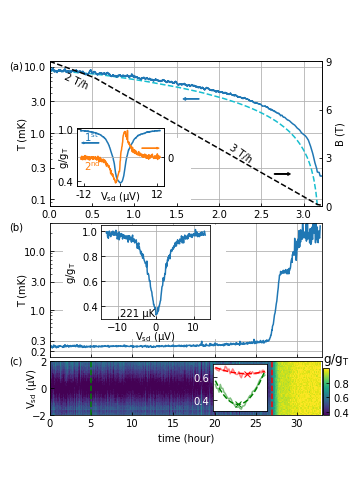

In [26]:
fig = plt.figure(figsize=(5, 8))
outer_gs = gridspec.GridSpec(2, 1, height_ratios=[6, 8], hspace=0.1, figure=fig)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer_gs[0])
gs2 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer_gs[1], hspace=0.05, height_ratios=[5, 2])
ax=[]
ax.append(plt.subplot(gs1[0]))
ax.append(plt.subplot(gs2[0]))
ax.append(plt.subplot(gs2[1]))

# Precool
#ax[0].plot(t_precool/3600, TCu_precool*1e3, label=r"$\mathrm{T_{CBT}}$")
#ax[0].plot(tmc_precool/3600, Tmc_precool*1e3, color=colors[6], label=r"$\mathrm{T_{MC}}$")
#mag_lastindex = np.max(np.where(b_precool<9))
#ax[0].fill_between([t_precool[0]/3600, t_precool[mag_lastindex]/3600], [4,4], [30,30], color='k', alpha=0.1)
#ax[0].text(2, 5.5, "Field\nramp up")

#ax[0].set_ylabel("T (mK)")
#ax[0].grid()
#ax[0].legend()
#ax[0].set_xlim(0,40)
#ax[0].set_yticks(np.linspace(5,30,6))
#ax[0].set_ylim(4,30)

# Ideal demag
T0_ideal = np.mean(TCu_demag[0:30])
T_ideal = T0_ideal * b_demag/9
flt = b_demag > 0.050
ax[0].semilogy(t_demag[flt]/3600, T_ideal[flt]*1e3, '--', color=colors[9], label='Ideal')
print(f"Final temperature ideal demag: {T_ideal[flt][-1]*1e3:.3f} mK")

# Demagnetization
ax[0].semilogy(t_demag/3600, TCu_demag*1e3)
ax[0].grid()
ax[0].yaxis.set_label_coords(-.08,.5)
ax[0].set_xlim(0,t_demag[-1]/3600)
ax[0].set_ylim(0.08,12)
ax[0].set_yticks([0.1,0.3,1,3,10])
ax[0].get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax[0].arrow(0.55, 0.74, -0.05, 0, head_width=0.02, head_length=.01, color=colors[0], transform=ax[0].transAxes, zorder=10)
ax[0].arrow(0.825, 0.22, 0.05, 0, head_width=0.02, head_length=.01, color='k', transform=ax[0].transAxes, zorder=10)
ax[0].set_ylabel("T (mK)")

ax0r = ax[0].twinx()
ax0r.plot(t_demag/3600, b_demag, '--k')
ax0r.set_ylim(0,9)
ax0r.set_ylabel("B (T)")
ax0r.set_yticks([0,3,6,9])

ax0r.text(0.15, 7.3, "2 T/h", rotation=-25)
ax0r.text(2.1, 2.7, "3 T/h", rotation=-35)

# 2nd Harmonic Inset
ax0in  = ax[0].inset_axes([0.10, 0.14, 0.32, 0.4])
whiterect = patches.Rectangle((0.02, 0.02), 0.5, 0.45, linewidth=1, edgecolor='None', facecolor='w', zorder=2, transform=ax[0].transAxes)
ax[0].add_patch(whiterect)
ax0inr = ax0in.twinx()
l1, = ax0in.plot(vCu_2ndH*1e6, gCu_2ndH/gT_Cu)
ax0in.set_xlabel(r'$\mathrm{V_{sd}}$ (µV)', labelpad=-10)
ax0in.set_xticks([-12, 0, 12])
ax0in.set_xticklabels([r"-12", "", "12"])
ax0in.set_yticks([0.4, 1.0])
ax0in.set_ylabel(r'$\mathrm{g/g_T}$', labelpad=-14)
#ax0inr.set_ylabel(r'$\mathrm{2^{nd}}$ H', loc="bottom")
l2,  = ax0inr.plot(vCu_2ndH*1e6, VyCu2H_2ndH*1e6, color=colors[1])
ax0inr.set_yticks([0])
ax0inr.grid()
ax0inr.text(-12, 55, r"$\mathrm{1^{st}}$", color=colors[0])
ax0inr.text(-12, -45, r"$\mathrm{2^{nd}}$", color=colors[1])
ax0in.arrow(-7, 0.84, -5, 0, head_width=0.02, head_length=0.8, color=colors[0])
ax0in.arrow(7, 0.78, 5, 0, head_width=0.02, head_length=0.8, color=colors[1])
#ax0in.legend([l1, l2], ["1st H", "2nd H"], loc=4)

# Warm up
t = np.hstack([ta for ta in warmup_t]) - warmup_t[0][0]
g0 = np.hstack([ga for ga in warmup_g0])
ax[1].semilogy(t/3600, Tcbt_Cu(np.array(g0/gT_Cu), Ec=Ec_Cu*1e-3)*1e3)

ax[1].set_xticklabels([])
ax[1].set_ylim(0.16,30)
ax[1].set_ylabel("T (mK)")
ax[1].set_yticks([0.2, 0.3, 1, 3, 10])
ax[1].yaxis.set_label_coords(-.08,.5)
ax[1].get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax[1].grid()
# These two plots share the same x- (time-) axis.
ax[1].set_xlim(0,33)
ax[2].set_xlim(0,33)

# Low temperature inset
ax1in  = ax[1].inset_axes([0.19, 0.28, 0.4, 0.7])
whiterect = patches.Rectangle((0.05, 0.13), 0.6, 0.85, linewidth=1, edgecolor='None', facecolor='w', zorder=2, transform=ax[1].transAxes)
ax[1].add_patch(whiterect)
ax1in.plot(vCu_lowT*1e6, gCu_lowT/gT_Cu)
ax1in.text(-9.5, 0.32, f"{lowestT*1e6:.0f} µK")

ax1in.set_xlabel(r"$\mathrm{V_{sd}}$ (µV)")
ax1in.set_ylabel(r"$\mathrm{g/g_T}$")
ax1in.xaxis.set_label_coords(0.5,-0.11)
#ax1in.yaxis.set_label_coords(-0.16,.5)
ax1in.grid()

# Offset Voltage correction
cf = ax[2].pcolormesh((warmup_t[0]-warmup_t[0][0])/3600, warmup_v[0][:,0]*1e3, warmup_g2d[0]/gT_Cu, vmin=0.36, vmax=1.0)
cbax = fig.add_axes([0.905, 0.125, 0.017, 0.10])
cb = fig.colorbar(cf, cax=cbax, pad=0.0, orientation='vertical', ticks=[0.4, 0.6, 0.8])
cb.ax.set_title('$\mathrm{g/g_T}$', loc='left')

ax[2].set_xlabel("time (hour)")
ax[2].set_ylabel(r"$\mathrm{V_{sd}}$ (µV)")
ax[2].yaxis.set_label_coords(-0.04,.5)
ax[2].set_ylim(-2, +2)

# Slices of warm up inset
ax2in  = ax[2].inset_axes([0.6, 0.07, 0.2, 0.88])
#whiterect = patches.Rectangle((0.40, 0.065), 0.275, 0.880, linewidth=1, edgecolor='None', facecolor='w', alpha=0.8, zorder=2, transform=ax[2].transAxes)
#ax[2].add_patch(whiterect)

slices = [27, 5] # hours
t = warmup_t[0] - warmup_t[0][0]
for i, s in enumerate(slices):
    s_index = np.min(np.where(t/3600>s))
    ax[2].plot([t[s_index]/3600]*2, [-2,+2], '--', color="rgb"[i])
    ax2in.plot(warmup_v[0][:,s_index]*1e3, warmup_g2d[0][:, s_index]/gT_Cu, color="rgb"[i], alpha=0.5)
    
    a,b,c = np.polyfit(warmup_v[0][:,s_index], warmup_g2d[0][:, s_index], 2)
    v0 = -b/(2*a)
    g0 = (-b*b+4*a*c)/(4*a)
    poly = np.poly1d([a,b,c])
    gfit = poly(vfit)
    ax2in.plot(vfit*1e3, gfit/gT_Cu, '--', color="rgb"[i])
    ax2in.plot(v0*1e3, g0/gT_Cu, 'x', color="rgb"[i])

ax2in.set_xticks([])
ax2in.set_yticks([0.4, 0.6])
ax2in.tick_params(axis='y', labelcolor='w')

ax[0].text(-0.15, 0.95, "(a)", transform=ax[0].transAxes)
ax[1].text(-0.15, 0.95, "(b)", transform=ax[1].transAxes)
ax[2].text(-0.15, 0.95, "(c)", transform=ax[2].transAxes)

fig.savefig("demag50mT.pdf", transparent=True, bbox_inches = 'tight', pad_inches=0.02)

Text(0, 0.5, 'Temperature (K)')

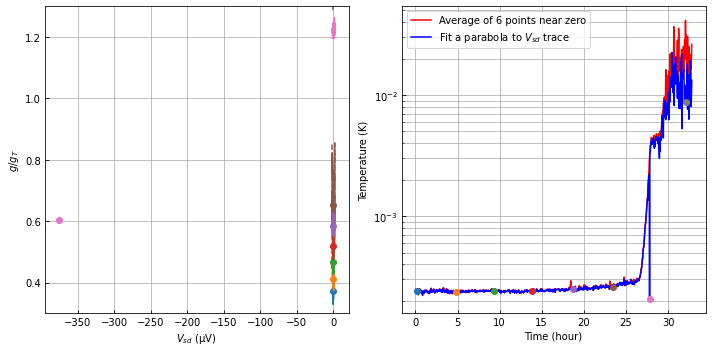

In [6]:
step=100
fig, ax = plt.subplots(1,2,figsize=(10,5))
vfit = np.linspace(-0.002, 0.002, 202)
Tpoly = np.zeros(len(warmup_t[0]))
for i in range(0,len(warmup_t[0])):
    a,b,c = np.polyfit(warmup_v[0][:,i], warmup_g2d[0][:,i]/gT_Cu, 2)
    if -b/(2*a) < 2 and -b/(2*a) > -2 and a > 0:
        g0gT = (-b*b+4*a*c)/(4*a)
    else:
        poly = np.poly1d([a,b,c])
        gfit = poly(vfit)
        g0gT = np.min(gfit)
    Tpoly[i] = Tcbt_Cu(g0gT, Ec_Cu*1e-3)
    if i%step==4:
        poly = np.poly1d([a,b,c])
        gfit = poly(vfit)
        color = colors[int(i/step)%10]
        ax[0].plot(warmup_v[0][:,i]*1e3, warmup_g2d[0][:,i]/gT_Cu+i/2000, color=color)
        ax[0].plot(vfit*1e3, gfit+i/2000, '--', color=color)
        ax[0].plot([-b/(2*a)*1e3], [(-b*b+4*a*c)/(4*a) +i/2000], 'o', color=color)
ax[0].grid()
ax[0].set_ylim(0.3, 1.3)
ax[0].set_xlabel(r"$V_{sd}$ (µV)")
ax[0].set_ylabel(r"$g/g_T$")

ax[1].semilogy((warmup_t[0]-warmup_t[0][0])/3600, Tcbt_Cu(np.array(warmup_g0[0]/gT_Cu), Ec=Ec_Cu*1e-3), label="Average of 6 points near zero", color='r')
ax[1].semilogy((warmup_t[0]-warmup_t[0][0])/3600, Tpoly, label=r"Fit a parabola to $V_{sd}$ trace", color='b')

for i in range(0,len(warmup_t[0]), step):
    ax[1].semilogy([(warmup_t[0][i+4]-warmup_t[0][0])/3600], [Tpoly[i+4]], 'o', color=colors[int(i/step)%10])
ax[1].legend()
ax[1].grid(which='both')
ax[1].set_xlabel("Time (hour)")
ax[1].set_ylabel("Temperature (K)")

Text(0.5, 1.0, '$B_f$=50 mT')

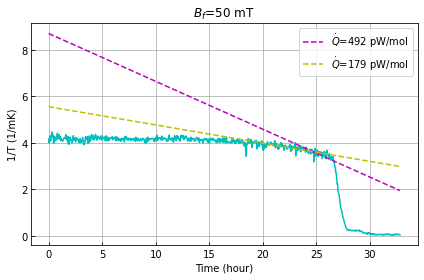

In [7]:
t = np.hstack([ta for ta in warmup_t]) - warmup_t[0][0]
g0 = np.hstack([ga for ga in warmup_g0])
OneOverT = 1/(Tcbt_Cu(g0/gT_Cu, Ec=Ec_Cu*1e-3))

#start_from_fit = warmup_rules[key]["heatfitrange"][0] #starts[np.argmax(R2s)]
flt = np.logical_and(t/3600>20, t/3600<26)
linfit, cov = np.polyfit(t[flt], OneOverT[flt], 1, cov=True)
heatleak_fit = -Cu_CC * Bf**2 / (mu0 * (1/linfit[0] + Cu_Korringa))

fig, ax = plt.subplots()
ax.plot(t/3600, OneOverT*1e-3, 'c')

heatleak = 4.92e-10
slope = 1/(-Cu_CC * Bf**2 / (mu0 * heatleak) - Cu_Korringa)
ax.plot(t/3600, (slope*t)*1e-3 +8.7, '--m', label=f"$\dot{{Q}}$={heatleak*1e12:.0f} pW/mol")
ax.plot(t/3600, (linfit[0]*t+linfit[1])*1e-3, '--y', label=f"$\dot{{Q}}$={heatleak_fit*1e12:.0f} pW/mol")

ax.set_xlabel("Time (hour)")
ax.set_ylabel("1/T (1/mK)")
ax.grid()
ax.legend()
ax.set_title(f"$B_f$={Bf*1e3:.0f} mT")